# Autmatic Modulation Classification

In this notebook we will cover some basics concepts of Automatic Modulation Classification (AMC), including statistical methods as well as a simple machine learning algorithm, known as Logistic Regression.

The contents of this notebook will cover:

* Modulated Data Generation
* Statistics-Based Classification
    * Higher Order Moments
    * Decision Tree Classifier
* Machine Learning-Based Classification
    * Binary Logistic Regression
    * Multi-Class Logistic Regression
    
Throughout this notebook we will only be using Numpy and Matplotlib to define and train our classifiers. Once you understand the basics you can always leverage specialized machine learning libraries, such as sci-kit to do your machine learning!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Modulated Data Generation

First we will define some functions to ease the generation of modulated data we will be working with throughout this notebook. We will be making simple models that are able of classifying Binary Phase Shift Keying (BPSK), (Quadrature Phase Shift Keying) QPSK, Quadrature Amplitude Modulation (QAM) and  Amplitude Shift Keying (ASK).

We will also be adding some additive white gaussian noise (AWGN) to all our waveforms, the reason for this is two-fold - we will want to test the robustness of our classifiers and when computing statistics, adding a bit of noise can avoid some division by zero warnings when computing higher order moments.

In [2]:
# Function to add white gaussian noise to a signal, specify SNR in dB
def awgn(signal, snr):
    sig_power = np.mean(np.abs(signal)**2) # calculate signal power
    sig_power_db = 10* np.log10(sig_power) # convert to dB

    noise_power_db = sig_power_db - snr
    noise_power = 10**(noise_power_db / 10)

    complex_noise = np.sqrt(noise_power/2)*(np.random.randn(len(signal)) + \
                                            np.random.randn(len(signal))*1j)

    return signal + complex_noise

# Function to generate BPSK
def generate_bpsk(num_symbols, noise=50):
    bits = np.random.randint(0,2,num_symbols)
    bpsk_scheme = [1+0j, -1+0j]
    bpsk_symbols = np.array([bpsk_scheme[i] for i in bits])
    
    bpsk_symbols = awgn(bpsk_symbols, noise)
    
    return bpsk_symbols

# Function to generate QPSK
def generate_qpsk(num_symbols, noise=50):
    qpsk_scheme= [1+1j, 1-1j, -1+1j, -1-1j]
    ints = np.random.randint(0,4,num_symbols)
    qpsk_symbols = np.array([qpsk_scheme[i] for i in ints])/np.sqrt(2)

    qpsk_symbols = awgn(qpsk_symbols, noise)
    
    return qpsk_symbols

# Function to generate QAM
def generate_qam(num_symbols, noise=50):
    qam_scheme = [-3-3j, -3-1j, -3+3j, -3+1j,  \
                  -1-3j, -1-1j, -1+3j, -1+1j,  \
                   3-3j,  3-1j,  3+3j,  3+1j,  \
                   1-3j,  1-1j,  1+3j,  1+1j]
    ints = np.random.randint(0,16,num_symbols)
    qam_symbols = np.array([qam_scheme[i] for i in ints])
    qam_symbols = qam_symbols/np.mean(np.abs(qam_scheme))
    
    qam_symbols = awgn(qam_symbols, noise)
    
    return qam_symbols

# Function to generate 4-ASK
def generate_ask4(num_symbols, noise=50):
    ask4_scheme = [3+0j, 1+0j, -1+0j, -3+0j]
    ints = np.random.randint(0,4,num_symbols)
    ask4_symbols = np.array([ask4_scheme[i] for i in ints])
    ask4_symbols = ask4_symbols/np.mean(np.abs(ask4_scheme))
    
    ask4_symbols = awgn(ask4_symbols, noise)
    
    return ask4_symbols

bpsk_symbols = generate_bpsk(64)
qpsk_symbols = generate_qpsk(64)
qam_symbols = generate_qam(64)
ask4_symbols = generate_ask4(64)

Let us look at the signals we are dealing with

Text(0.5, 1.0, '4-ASK')

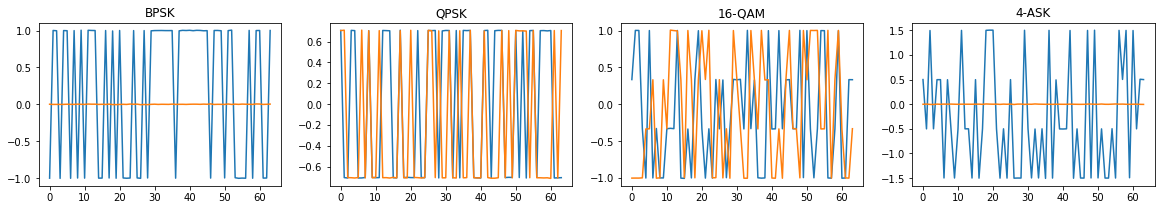

In [3]:
fig, ax = plt.subplots(1,4, figsize=(20,3))

ax[0].plot(bpsk_symbols.real)
ax[0].plot(bpsk_symbols.imag)
ax[0].set_title('BPSK')

ax[1].plot(qpsk_symbols.real)
ax[1].plot(qpsk_symbols.imag)
ax[1].set_title('QPSK')

ax[2].plot(qam_symbols.real)
ax[2].plot(qam_symbols.imag)
ax[2].set_title('16-QAM')

ax[3].plot(ask4_symbols.real)
ax[3].plot(ask4_symbols.imag)
ax[3].set_title('4-ASK')

## Statistics-Based Classification

A common method of classification, without machine learning, has historically been analytical - exploring the statistics of signals and manually determining classification rules based on that analysis. One way of doing this is by extracting the instantaneous amplitude $A(t)$ and instantaneous phase $\theta(t)$, of a time domain signal $x(t)$, which is made up of real and imaginary components. In Numpy we can do this by using np.abs and np.angle functions.

Once we extract these instantaneous values, we can compute various statistics about them. 

**Higher Order Moments**

The definition of $n^{th}$ order moment is given by

$\mu_{n} = E[(x-E[x])^{n}]$

Here E[x] is our expected value (or more practically the mean) of a random variable x, and $n$ is the order of our moment. The first and 2nd order moments you may be familiar with as they have names - the mean and variance. Once we go above the 2nd order moment we will more commonly see the standardized moments used, defined as

$\tilde{\mu_{n}} = \frac{E[(x-E[x])^{n}]}{(E[(x-E[x])^{2}])^{n/2}}$

The normalization here is a division by the standard deviation, making these moments scale invariant - which is a useful property in machine learning classification at the very least as we normally want to somehow normalize our inputs anyway. The 3rd and 4th order standardized moments are called *skewness* and *kurtosis*, respectively, and are heavily used in statistics.

For our examples we will be computing the variance, skewness and kurtosis of the instantaneous amplitude and phase values for our signals. Note that we may not use all of them right now, but will take advantage later sections of the notebook.

In [4]:
def calculate_statistics(x):
    
    # Extract instantaneous amplitude and phase
    inst_a = np.abs(x) 
    inst_p = np.angle(x)

    # Amplitude statistics
    m2_a = np.mean((inst_a-np.mean(inst_a))**2) # variance of amplitude
    m3_a = np.mean((inst_a-np.mean(inst_a))**3)/(np.mean((inst_a-np.mean(inst_a))**2)**(3/2)) # skewness of amplitude
    m4_a = np.mean((inst_a-np.mean(inst_a))**4)/(np.mean((inst_a-np.mean(inst_a))**2)**(2)) # kurtosis of amplitude
    
    # Phase statistics
    m2_p = np.mean((inst_p-np.mean(inst_p))**2) # variance of phase
    m3_p = np.mean((inst_p-np.mean(inst_p))**3)/(np.mean((inst_p-np.mean(inst_p))**2)**(3/2)) # skewness of phase
    m4_p = np.mean((inst_p-np.mean(inst_p))**4)/(np.mean((inst_p-np.mean(inst_p))**2)**(2)) # kurtosis of phase
    
    return  m2_a, m3_a, m4_a, m2_p, m3_p, m4_p

We can get a snapshot of our statistical values for these modulation schemes to determine which ones would make sense to use for classification.

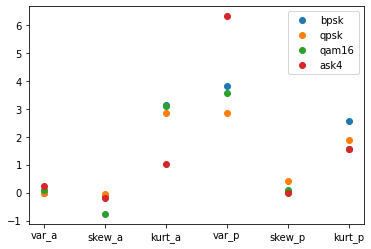

In [5]:
plt.plot(calculate_statistics(bpsk_symbols), 'o')
plt.plot(calculate_statistics(qpsk_symbols), 'o')
plt.plot(calculate_statistics(qam_symbols), 'o')
plt.plot(calculate_statistics(ask4_symbols), 'o')
plt.xticks([0,1,2,3,4,5], ['var_a', 'skew_a', 'kurt_a', 'var_p', 'skew_p', 'kurt_p'])
plt.legend(('bpsk', 'qpsk', 'qam16', 'ask4'))

Based on a glance of these statistics, we can see that the kurtosis of our instantaneous amplitude and variance of the instantaneous phase of these signals can be good indicators to separate the modulation schemes. For example, we could use the phase variance to separate BPSK/4-ASK and QPSK/16-QAM into 2 subgroups. Then use the kurtosis of the amplitude to further discern between BPSK vs 4-ASK and QPSK vs 16-QAM.

Note that this is a very simplified example, and there are a variety of other features one could take advantage of, such as ones based on instantaenous frequency or even spectral fft-based features!

**Create Decision Tree Classifier**

Now that we have identified the main statistical features we can use to tell our signals apart, we can implement a decision tree model, which is essentially a number of threshold and branches defined by if statements.

In [6]:
def dt_classifier(x):
    _, _, a_kurt, p_var, _, _ = calculate_statistics(x)
    
    if p_var > 4:#3.6:
        if a_kurt > 2:
            return 0 # predict BPSK
        else:
            return 3 # predict 4-ASK
    elif a_kurt > 2.5:
        return 1 # predict QPSK
    else:
        return 2 # predict 16-QAM

To make life a bit easier, we can make a class dictionary to easy convert between predicted numbers and names of our schemes.

In [7]:
classes = {0: 'BPSK', 1:'QPSK', 2:'16-QAM', 3:'4-ASK'}

Do a sanity check to make sure that it makes correct predictions for our example waveforms.

In [8]:
print(classes[dt_classifier(bpsk_symbols)])
print(classes[dt_classifier(qpsk_symbols)])
print(classes[dt_classifier(qam_symbols)])
print(classes[dt_classifier(ask4_symbols)])

QPSK
QPSK
QPSK
4-ASK


**Decision Tree  Accuracy Evaluation**

Now that we have a model, it would be a good idea to find out how robust it is for different channel conditions. Here we loop over a range of SNR values, generate 100 modulated waveforms per modulation scheme and see how many of our predictions were correct.

In [9]:
snrs = np.arange(0,25)
num_symbols = 256
num_examples = 500

bpsk_results, qpsk_results, qam_results, ask4_results = [], [], [], []

for i in range(len(snrs)):
    snr = snrs[i]
    
    # Generate all waveforms
    bpsk_data = np.array([generate_bpsk(num_symbols,snr) for i in range(num_examples)])
    qpsk_data = np.array([generate_qpsk(num_symbols,snr) for i in range(num_examples)])
    qam16_data = np.array([generate_qam(num_symbols,snr) for i in range(num_examples)])
    ask4_data = np.array([generate_ask4(num_symbols,snr) for i in range(num_examples)])
    
    bpsk_acc = np.mean([dt_classifier(x)==0 for x in bpsk_data])*100
    qpsk_acc = np.mean([dt_classifier(x)==1 for x in qpsk_data])*100
    qam_acc = np.mean([dt_classifier(x)==2 for x in qam16_data])*100
    ask4_acc = np.mean([dt_classifier(x)==3 for x in ask4_data])*100
    
    bpsk_results.append(bpsk_acc)
    qpsk_results.append(qpsk_acc)
    qam_results.append(qam_acc)
    ask4_results.append(ask4_acc)
    
    print('For SNR={}dB, BPSK: {:.2f}%, QPSK: {:.2f}%, 16-QAM: {:.2f}%, 4-ASK: {:.2f}%'.format(snr, bpsk_acc, qpsk_acc, qam_acc, ask4_acc))

For SNR=0dB, BPSK: 6.40%, QPSK: 89.20%, 16-QAM: 11.80%, 4-ASK: 0.00%
For SNR=1dB, BPSK: 10.60%, QPSK: 84.00%, 16-QAM: 17.40%, 4-ASK: 0.00%
For SNR=2dB, BPSK: 17.60%, QPSK: 89.20%, 16-QAM: 20.00%, 4-ASK: 0.00%
For SNR=3dB, BPSK: 31.00%, QPSK: 89.40%, 16-QAM: 24.20%, 4-ASK: 0.00%
For SNR=4dB, BPSK: 42.20%, QPSK: 90.60%, 16-QAM: 31.20%, 4-ASK: 0.00%
For SNR=5dB, BPSK: 60.00%, QPSK: 93.20%, 16-QAM: 32.00%, 4-ASK: 0.20%
For SNR=6dB, BPSK: 70.40%, QPSK: 95.40%, 16-QAM: 34.80%, 4-ASK: 5.40%
For SNR=7dB, BPSK: 81.20%, QPSK: 98.80%, 16-QAM: 44.40%, 4-ASK: 19.00%
For SNR=8dB, BPSK: 84.00%, QPSK: 97.20%, 16-QAM: 48.40%, 4-ASK: 50.40%
For SNR=9dB, BPSK: 89.00%, QPSK: 96.80%, 16-QAM: 51.20%, 4-ASK: 67.20%
For SNR=10dB, BPSK: 93.00%, QPSK: 97.00%, 16-QAM: 60.40%, 4-ASK: 78.60%
For SNR=11dB, BPSK: 97.60%, QPSK: 97.40%, 16-QAM: 66.00%, 4-ASK: 84.00%
For SNR=12dB, BPSK: 95.20%, QPSK: 96.00%, 16-QAM: 72.60%, 4-ASK: 89.60%
For SNR=13dB, BPSK: 97.60%, QPSK: 97.00%, 16-QAM: 77.00%, 4-ASK: 91.20%
For SNR=14

We can also plot our results for a succinct overview.

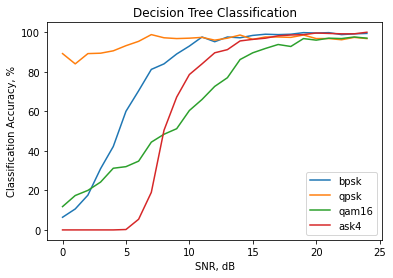

In [10]:
plt.plot(snrs, bpsk_results)
plt.plot(snrs, qpsk_results)
plt.plot(snrs, qam_results)
plt.plot(snrs, ask4_results)
plt.legend(('bpsk', 'qpsk', 'qam16', 'ask4'))
plt.ylabel('Classification Accuracy, %')
plt.xlabel('SNR, dB')
plt.title('Decision Tree Classification')
plt.show()

You can tell from the graph that the model performs extremely well for QPSK, but not quite as well for 16-QAM. We can get further insight on the performance of a classifier by plotting a confusion matrix.

**Confusion Matrix**

Confusion matrices are used very often when evaluating classifiers. Essentially it is a table where we plot the known labels (desired outputs of our classifier) on one axis and predicted labels on the other axis. An ideal classifier will produce a perfect diagonal, however realistic classifier will often misclassify one class as another, seeing exactly which classes get incorrectly misclassified can give us insight into which parts of our model to tune or correct.

We will first generate some test data, at SNR = 10dB.

In [11]:
snr = 10
num_symbols = 128
num_examples = 100

bpsk_test = np.array([generate_bpsk(num_symbols,snr) for i in range(num_examples)])
qpsk_test = np.array([generate_qpsk(num_symbols,snr) for i in range(num_examples)])
qam16_test = np.array([generate_qam(num_symbols,snr) for i in range(num_examples)])
ask4_test = np.array([generate_ask4(num_symbols,snr) for i in range(num_examples)])

Here we defined a one-hot encoding function, which converts an integer label to a one-hot vector, such as 0 (out of 4) -> [0 0 1 0], 1 -> [0 1 0 0], etc. Some multi-class classifiers require our labels to be one-hot encoded (e.g. neural networks will often be fed one-hot encoded labels during training). Right now we will be using it to more easily construct a confusion matrix.

In [12]:
def to_onehot(labels, num_classes):
    num_labels = len(labels)
    labels_onehot = np.zeros((num_labels, num_classes))
    labels_onehot[np.arange(num_labels),labels] = 1
    
    return labels_onehot

In [13]:
to_onehot([2], num_classes=4)

array([[0., 0., 1., 0.]])

In [14]:
np.argmax(to_onehot([2], num_classes=5))

2

Make predictions on our test data.

In [15]:
bpsk_predictions = [dt_classifier(x) for x in bpsk_test]
bpsk_labels = to_onehot(bpsk_predictions, len(classes))

qpsk_predictions = [dt_classifier(x) for x in qpsk_test]
qpsk_labels = to_onehot(qpsk_predictions, len(classes))

qam_predictions = [dt_classifier(x) for x in qam16_test]
qam_labels = to_onehot(qam_predictions, len(classes))

ask4_predictions = [dt_classifier(x) for x in ask4_test]
ask4_labels = to_onehot(ask4_predictions, len(classes))

# double check the expected shape
bpsk_labels.shape

(100, 4)

Note that our labels that the dimensions of our labels are now 500x4, in order to construct the cm we want to condense each one to 1x4 and concatenate them to make up a 4x4 matrix. We can do that by using the numpy sum function, and sum every column, by passing the axis=0 argument.

In [16]:
cm = np.vstack((np.sum(bpsk_labels,axis=0), np.sum(qpsk_labels,axis=0), np.sum(qam_labels,axis=0), np.sum(ask4_labels,axis=0)))

Now we can plot the confusion matrix.

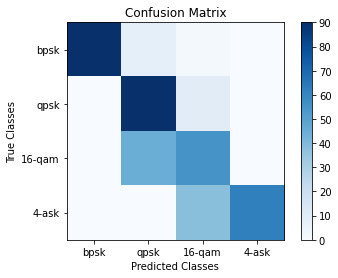

In [17]:
plt.imshow(cm, cmap='Blues')
plt.xticks([0,1,2,3], ['bpsk', 'qpsk', '16-qam', '4-ask'])
plt.yticks([0,1,2,3], ['bpsk', 'qpsk', '16-qam', '4-ask'])
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.title('Confusion Matrix')
plt.colorbar()

Based on our confusion matrix we can see that many 16-QAM instances get falsely misclassified as QPSK, same thing happens to a degree to BPSK. What this tells is that we could go back to our statistical features and perhaps tweak the values we use for QPSK and 16-QAM classification.

Now what if we don't want to tweak values manually, and would rather have it done automatically by the computer? Well this is where machine learning can come in handy.

## Machine Learning-Based Classification

In machine learning classification is typically considered a supervised learning task - meaning that we provide a model with data $x$ and desired responses or labels $y$, and it uses these to fit a function to best map these inputs $x$ to the desired outputs $y$, during training. An example of supervised learning is logistic regression, which we will be implementing to classify our modulated signals.

**Logistic Regression**

Logistic Regression is one of the simplest classification algorithms used today. Given our training data $\{x,y\}$ logistic regression works by fitting its hypothesis function $\hat{y} = f(x,w)$, where $w$ are weights that it needs to learn. If we took our decision tree as an example, we were hard coding weighings for different features, this time we will try to learn them by training a model.

The logistic regression forward pass is defined as

$\hat{y} = g(xw + b)$

where $x$ is our input vector, $w$ are the learned weights and $b$ is an added bias, which is also learned. g(.) is an activation function adding some non-linearity to our model. Typically the function used is the sigmoid function, defined as:

$g(x) = \frac{1}{1-e^{-x}}$

In [18]:
def sigmoid(y):
    return 1/(1+np.exp(-y))

What the sigmoid function does is squash our input into the range of $\in{(0,1)}$, where 0 is a negative and 1 is a positive classification.

Text(0.5, 1.0, 'Sigmoid Activation Function')

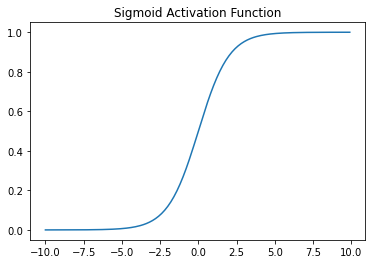

In [19]:
x = np.arange(-10,10,0.1)
plt.plot(x,sigmoid(x))
plt.title('Sigmoid Activation Function')

Now we can define the forward pass of our logistic model. **A note on bias**: in some literature bias is an extra term that is added in code $b$, in others it is considered another weight, e.g. $w_{0}$. For simplicity we will consider bias to be another weight to be learned, which means our weight vector will be (7,1), even though our number of features is 6. We can make the matrix multiplies work out by appending an additional 1 to our feature vector. Mathematically these are equivalent.

In [20]:
def forward(x, weights):
    y = np.dot(x, weights) # weights
    z = sigmoid(y) # sigmoid activation
    return z

We also need a metric to tell our machine learning model how well it is doing, otherwise how will we know if it is learning? These metrics are usually referred to cost (or loss) functions. For logistic regression we use the log loss, as defined:

$Cost(y,\hat{y}) = \frac{1}{m}\sum^{m}_{i=0} y_{i} log(\hat{y_{i}}) + (1 - y_{i}) log(1 - \hat{y_{i}})$

where m is the number of examples, $y$ are the labels, and $\hat{y}$ are the model predictions. The cost will be high if our predictions are far from the labelled data, and low (ideally 0) if all model predictions are correct.

In [21]:
def cost(x, y, w):
    y_hat = forward(x,w)
    cost = (np.matmul(-y.T, np.log(y_hat)) - np.matmul((1 -y.T), np.log(1 - y_hat)))/x.shape[0]
    return cost

**Gradient Descent**

Gradient descent is the bread and butter of the overwhelming majority machine learning algorithms. There are derivatives and other additions one can make, but at the heart of it is usually gradient descent. Here we use the basic version as defined by

$\Delta w = 1/m \sum^{m}_{i=0} x_{i} (h(x_{i},w) - y_{i})$

where $\Delta w$ is the gradient of our weights, $m$ is the number of training samples, $h$ represents our logistic regression hypothesis function and $y$ are our labels. We use the gradient to nudge our weights in the direction where the cost will be smaller, so that the next time our model sees the same data it can more accurately predict the output. 

The amount "nudging" is controlled by the learning rate $\alpha$, and we can define the rule for acquiring new weights per gradient descent iteration as:

$w = w - \alpha \Delta{w}$

In [22]:
def gradient_descent(x, y, w, lr):
    m = x.shape[0]
    h = forward(x, w)
    grad = np.matmul(x.T, (h - y)) / m;
    w = w - lr * grad
    return w

**Generate training data**

Simple logistic regression is a binary classifier, which means it can only classify two classes. Here we will generate some training data and evaluate a binary QPSK vs 4-ASK classifier. Note that the shape of our training data is 7 columns wide, because we added an additional bias term of all ones.

In [23]:
bpsk_train = np.array([calculate_statistics(awgn(generate_bpsk(256),30)) for i in range(100)])
# ask4_train = np.array([calculate_statistics(awgn(generate_ask4(128),30)) for i in range(100)])
qpsk_train = np.array([calculate_statistics(awgn(generate_qpsk(256),30)) for i in range(100)])

x = np.concatenate((bpsk_train, qpsk_train))
x = np.concatenate((x, np.ones((200,1))),axis=1) # add bias
x.shape

(200, 7)

We also need to generate corresponding labels. We expect 4-ASK to produce an output of 0, and QPSK an output of 1.

In [24]:
bpsk_labels = np.zeros((100,1))
qpsk_labels = np.ones((100,1))
y = np.concatenate((bpsk_labels, qpsk_labels))
y.shape

(200, 1)

Initialize the weights

In [26]:
w = np.random.randn(7,1)

Now train our classifier for 50 iterations, meaning we will train the model on our training set 50 times fully.

In [27]:
costs = []

for i in range(50):
    w = gradient_descent(x,y,w,0.5)
    costs.append(cost(x,y,w).squeeze())

We can see that our cost is going down as we train the model, which is what we expect!

Text(0, 0.5, 'Log Loss')

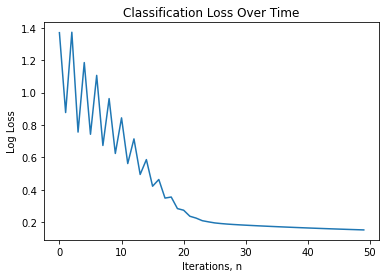

In [28]:
plt.plot(costs)
plt.title('Classification Loss Over Time')
plt.xlabel('Iterations, n')
plt.ylabel('Log Loss')

**Evaluate Binary Logistic Regression**

Now that we have the weights of logistic regression, we can define a new prediction function that would not require us to add a bias term to our data, but instead will just use the weight vector.

In [29]:
def predict(x,w):
    
    y = np.dot(x, w[:-1]) + w[-1] # weights
    z = 1/(1+np.exp(-y)) # sigmoid activation
    
    if z >= 0.5:
        return 1
    else:
        return 0

Let's generate a new QPSK waveform and see how our network would predict it.

In [30]:
new_data = calculate_statistics(awgn(generate_bpsk(256),30))
classes[predict(new_data,w)]

'BPSK'

So far so good! Let us try to do the same as our decision tree classifier over an SNR range.

In [37]:
snrs = np.arange(0,25)
num_symbols = 256
num_examples = 500

bpsk_results, qpsk_results = [], []

for i in range(len(snrs)):
    snr = snrs[i]
    
    # Generate all waveforms
    bpsk_data = np.array([awgn(generate_bpsk(num_symbols),snr) for i in range(num_examples)])
#     ask4_data = np.array([awgn(generate_ask4(num_symbols),snr) for i in range(num_examples)])
    qpsk_data = np.array([awgn(generate_qpsk(num_symbols),snr) for i in range(num_examples)])
    
    bpsk_acc = np.mean([predict(calculate_statistics(x),w)==0 for x in bpsk_data])*100
#     ask4_acc = np.mean([predict(calculate_statistics(x),w)==1 for x in ask4_data])*100
    qpsk_acc = np.mean([predict(calculate_statistics(x),w)==1 for x in qpsk_data])*100
    
    bpsk_results.append(bpsk_acc)
    qpsk_results.append(qpsk_acc)
    
    print('For SNR={}dB, BPSK: {:.2f}%, QPSK: {:.2f}%'.format(snr, bpsk_acc, qpsk_acc))

For SNR=0dB, BPSK: 16.40%, QPSK: 98.80%
For SNR=1dB, BPSK: 27.40%, QPSK: 97.20%
For SNR=2dB, BPSK: 35.00%, QPSK: 98.20%
For SNR=3dB, BPSK: 51.80%, QPSK: 95.40%
For SNR=4dB, BPSK: 58.80%, QPSK: 97.80%
For SNR=5dB, BPSK: 69.80%, QPSK: 96.80%
For SNR=6dB, BPSK: 75.80%, QPSK: 96.80%
For SNR=7dB, BPSK: 78.00%, QPSK: 98.60%
For SNR=8dB, BPSK: 78.20%, QPSK: 98.60%
For SNR=9dB, BPSK: 81.20%, QPSK: 98.00%
For SNR=10dB, BPSK: 85.60%, QPSK: 99.00%
For SNR=11dB, BPSK: 86.80%, QPSK: 99.60%
For SNR=12dB, BPSK: 91.20%, QPSK: 99.00%
For SNR=13dB, BPSK: 89.40%, QPSK: 99.20%
For SNR=14dB, BPSK: 92.00%, QPSK: 98.80%
For SNR=15dB, BPSK: 94.00%, QPSK: 98.80%
For SNR=16dB, BPSK: 94.00%, QPSK: 98.60%
For SNR=17dB, BPSK: 94.60%, QPSK: 98.60%
For SNR=18dB, BPSK: 94.80%, QPSK: 99.00%
For SNR=19dB, BPSK: 95.00%, QPSK: 99.00%
For SNR=20dB, BPSK: 96.40%, QPSK: 98.60%
For SNR=21dB, BPSK: 96.40%, QPSK: 98.80%
For SNR=22dB, BPSK: 96.60%, QPSK: 98.80%
For SNR=23dB, BPSK: 96.40%, QPSK: 99.60%
For SNR=24dB, BPSK: 97.00%

Plotting the results, we can see that for at least BPSK and QPSK, we achieved similar classification curves than the ones we manually set in our decision tree classifier. Except this time we didn't have to look at the statistics or set anything manually, but the learning rate of our gradient descent algorithm.

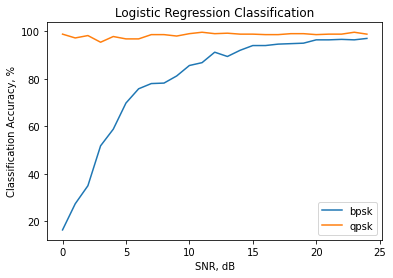

In [38]:
plt.plot(snrs, bpsk_results)
plt.plot(snrs, qpsk_results)
plt.legend(('bpsk', 'qpsk'))
plt.ylabel('Classification Accuracy, %')
plt.xlabel('SNR, dB')
plt.title('Logistic Regression Classification')
plt.show()

## Multi-class Logistic Regression